<a href="https://colab.research.google.com/github/paulw-edu/ML_CV_bark_classification/blob/main/Bark_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Create a Dataset from all the Images

In [2]:
import tensorflow as tf

image_size = (512,512)

# Generate a training Dataset from the Internet Images
train_ds = tf.keras.utils.image_dataset_from_directory(
  "/content/drive/MyDrive/Bark_scaled/internet_v2/",
  image_size=image_size,
  crop_to_aspect_ratio=True,
  batch_size=64)

# Generate a dev set from the self labeled images
dev_ds = tf.keras.utils.image_dataset_from_directory(
  "/content/drive/MyDrive/Bark_scaled/self_labeled/",
  image_size=image_size,
  crop_to_aspect_ratio=True,
  batch_size=64)

class_names = train_ds.class_names
num_classes = len(class_names)

Found 21491 files belonging to 8 classes.
Found 333 files belonging to 8 classes.


Create Weights for all the classes (for the training Dataset), 
so that biases in the training data won't affect the Model too much


In [3]:
import os

baseDir = "/content/drive/MyDrive/Bark_scaled/internet_v2/"
fileCount = {}
accumulate = 0.0
for i in range(len(class_names)):
    files = os.listdir(baseDir+class_names[i])
    Nrfiles = len(files)
    fileCount[i] = Nrfiles
    accumulate += Nrfiles
    print(f"{i} - {class_names[i]}: {Nrfiles}")
print(f"total: {accumulate}")
class_weight = {k: accumulate/v for k, v in fileCount.items()}
print(f"class Weight: {class_weight}")

0 - ash: 1619
1 - beech: 1521
2 - birch: 2660
3 - fir: 2101
4 - larch: 2074
5 - oak: 3957
6 - pine: 3801
7 - spruce: 3758
total: 21491.0
class Weight: {0: 13.274243360098826, 1: 14.129520052596975, 2: 8.079323308270677, 3: 10.22893860066635, 4: 10.362102217936355, 5: 5.431134698003538, 6: 5.654038410944488, 7: 5.718733368813199}


Import the pre trained Model

In [12]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

# clear the old session
keras.backend.clear_session() 

# create the base pre-trained model
input_tensor = layers.Input(shape=(image_size[0], image_size[1], 3))
i = layers.Rescaling(1.0 / 255)(input_tensor) # do rescaling
#base_model = InceptionV3(input_tensor=i, weights='imagenet', include_top=False)
#base_model = MobileNetV2(input_tensor=i, weights='imagenet', include_top=False)
#base_model = VGG16(input_tensor=i, weights='imagenet', include_top=False)
base_model = VGG19(input_tensor=i, weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = layers.Dense(num_classes, activation='softmax')(x)

# this is the model we will train
model = keras.models.Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
# use sparce categorical crossentropy because labels are integer encoded in the dataset
model.compile(optimizer='adam', loss=keras.losses.sparse_categorical_crossentropy,metrics=['accuracy'])

80134624/80134624 [==============================] - 4s 0us/step


Show the Model (this should also be put in the docs)

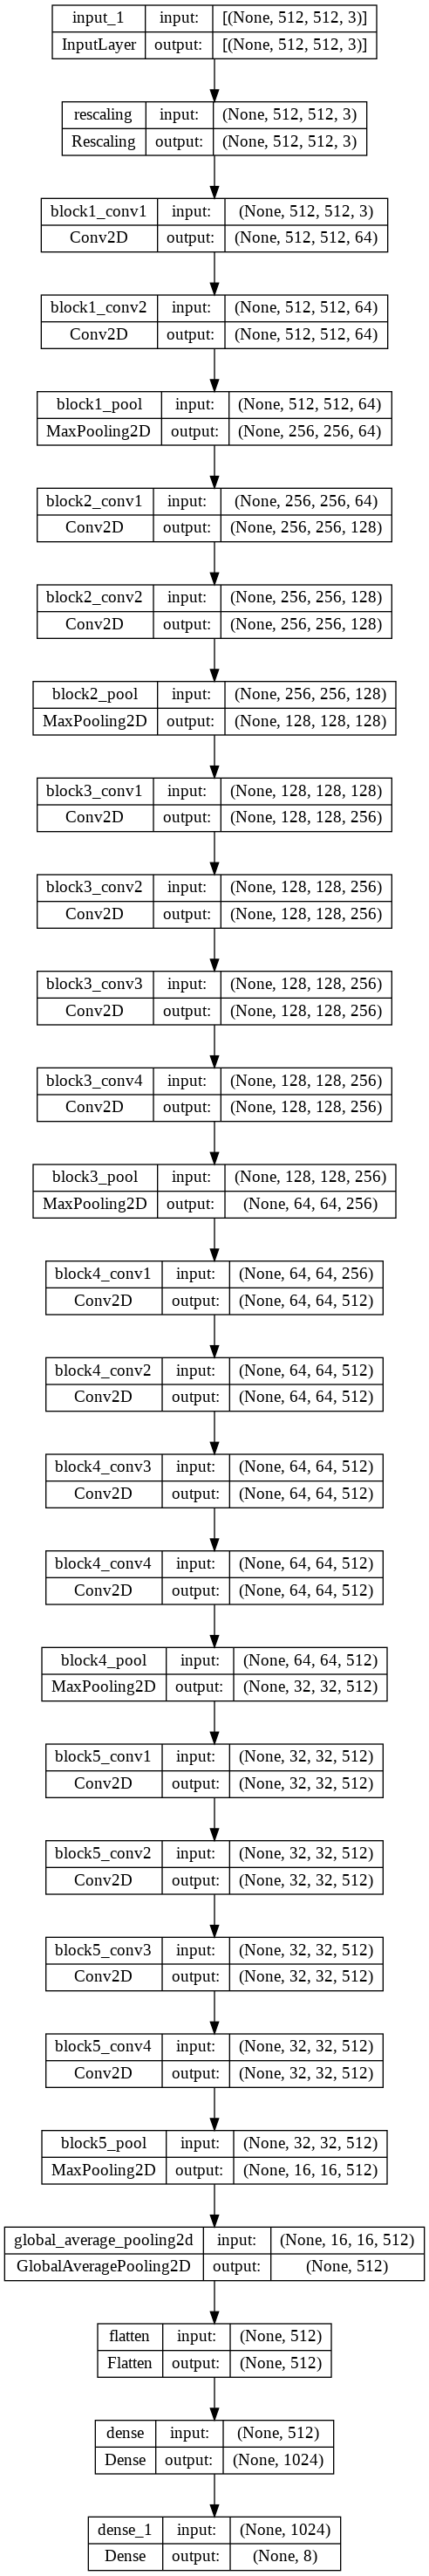

In [13]:
# Show how the model is build
keras.utils.plot_model(model, show_shapes=True)

Train the Model on the Training Data 

the number of epochs and the steps per epoch should be adjusted on the fly, depending on the goal of training. (if it is just for testing or the final training etc.)

In [6]:
# train the model on the new data for a few epochs
print("training...")
history = model.fit(
    x=train_ds, 
    validation_data=dev_ds, 
    class_weight=class_weight, 
    steps_per_epoch=10,
    validation_steps=5,
    verbose=1, 
    epochs=2
    )

training...
Epoch 1/2
10/10 [==============================] - 476s 32s/step - loss: 13.3731 - accuracy: 0.4500 - val_loss: 1.7693 - val_accuracy: 0.3063
Epoch 2/2
10/10 [==============================] - 164s 18s/step - loss: 7.2365 - accuracy: 0.6719 - val_loss: 2.3190 - val_accuracy: 0.4094


Plot the History

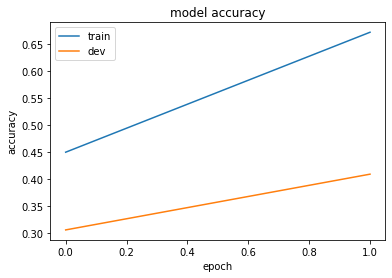

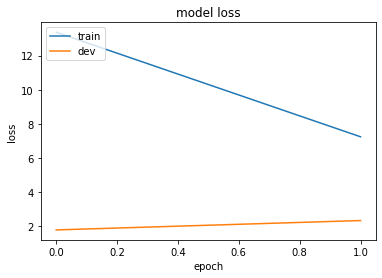

In [7]:
import matplotlib.pyplot as plt

def show_history(history):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'dev'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'dev'], loc='upper left')
    plt.show() 

show_history(history)

Try out the Model and assess its Performance

In [ ]:
# check the Images that make problems in the dev set
predictions = model.predict(dev_ds)
score = model.evaluate(dev_ds) 


6/6 [==============================] - 5s 649ms/step - loss: 2.1445 - accuracy: 0.4024


Plot the Models guesses depending on class.
so how often the Model predicts a specific class if the input image is from another or the same class

on the left is the true class and then the prediction percentage of the Model.

absolute=True uses the Max value of the Models prediction probabilities only and
absolute=False uses all the probabilities of the Model predictions to generate the table

This shows which categories are Similar to other categories.
Meaning the categories where the Model guesses wrong often either have a discrepancy between training and dev data or are simmilar to another category.

This could be because the Datasets are an accumulation of different tree species in the same supercategory while the Data from the Dev set is mainly from one exact species in that supercategory.

In [ ]:
import numpy as np

def plot_model_predictions(class_names, predictions, dev_ds, absolute=True):
    index = 0
    acc = np.zeros((len(class_names),len(class_names)))
    for (x,y) in dev_ds:
        valY = tf.keras.backend.get_value(y)
        valX = tf.keras.backend.get_value(y)
        for i in range(len(valY)):
            y = valY[i]
            pred = predictions[index]
            if absolute:
              acc[y,pred.argmax()]+=1
            else:
              acc[y,:] += pred
            index +=1


    print('class  ', end='')
    for c in class_names:
        print(f'{c:<7}', end='')
    print('')
    for i in range(len(acc)):
        print(f'{class_names[i]:<7}', end='')
        for j in range(len(class_names)):
            all_guesses = sum(acc[i])
            print(f'{acc[i][j]/all_guesses:<7,.2f}', end='')
        print('')
  
plot_model_predictions(class_names, predictions, dev_ds, True)

class  ash    beech  birch  fir    larch  oak    pine   spruce 
ash    0.00   0.14   0.00   0.00   0.43   0.29   0.14   0.00   
beech  0.00   0.25   0.00   0.02   0.07   0.39   0.16   0.12   
birch  0.00   0.25   0.00   0.00   0.04   0.33   0.25   0.12   
fir    0.00   0.23   0.00   0.00   0.09   0.64   0.05   0.00   
larch  0.03   0.19   0.00   0.03   0.10   0.39   0.16   0.10   
oak    0.00   0.28   0.00   0.00   0.07   0.35   0.14   0.16   
pine   0.04   0.13   0.00   0.00   0.04   0.53   0.16   0.09   
spruce 0.03   0.22   0.00   0.00   0.10   0.32   0.21   0.14   


Improve the model by learnin the first few layers

In [ ]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss=keras.losses.sparse_categorical_crossentropy)

0 input_1
1 rescaling
2 conv2d
3 batch_normalization
4 activation
5 conv2d_1
6 batch_normalization_1
7 activation_1
8 conv2d_2
9 batch_normalization_2
10 activation_2
11 max_pooling2d
12 conv2d_3
13 batch_normalization_3
14 activation_3
15 conv2d_4
16 batch_normalization_4
17 activation_4
18 max_pooling2d_1
19 conv2d_8
20 batch_normalization_8
21 activation_8
22 conv2d_6
23 conv2d_9
24 batch_normalization_6
25 batch_normalization_9
26 activation_6
27 activation_9
28 average_pooling2d
29 conv2d_5
30 conv2d_7
31 conv2d_10
32 conv2d_11
33 batch_normalization_5
34 batch_normalization_7
35 batch_normalization_10
36 batch_normalization_11
37 activation_5
38 activation_7
39 activation_10
40 activation_11
41 mixed0
42 conv2d_15
43 batch_normalization_15
44 activation_15
45 conv2d_13
46 conv2d_16
47 batch_normalization_13
48 batch_normalization_16
49 activation_13
50 activation_16
51 average_pooling2d_1
52 conv2d_12
53 conv2d_14
54 conv2d_17
55 conv2d_18
56 batch_normalization_12
57 batch_norma

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
history2 = model.fit(x=train_ds, validation_data=dev_ds, verbose=1, epochs=10)

Epoch 1/10
254/254 [==============================] - 135s 503ms/step - loss: 0.9778
Epoch 2/10
254/254 [==============================] - 128s 501ms/step - loss: 0.3524
Epoch 3/10
254/254 [==============================] - 127s 499ms/step - loss: 0.2455
Epoch 4/10
254/254 [==============================] - 127s 498ms/step - loss: 0.1818
Epoch 5/10
254/254 [==============================] - 127s 498ms/step - loss: 0.1505
Epoch 6/10
254/254 [==============================] - 128s 499ms/step - loss: 0.1246
Epoch 7/10
254/254 [==============================] - 127s 498ms/step - loss: 0.1068
Epoch 8/10
254/254 [==============================] - 127s 498ms/step - loss: 0.0912
Epoch 9/10
254/254 [==============================] - 128s 499ms/step - loss: 0.0818
Epoch 10/10
254/254 [==============================] - 127s 498ms/step - loss: 0.0710


In [ ]:
show_history(history2)